# Goal

Reproduce the parameter study of various bandit algorithms in Figure 2.6 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf), Chapter 2: Multi-armed Bandits.

![multiarmed bandit parameter study from Sutton & Barto](multiarmed_bandit_parameter_study.png "parameter study")

In [1]:
from abc import ABC, abstractmethod
from collections import OrderedDict

import numpy as np
import pandas as pd
import bionic as bn

/home/cathy/.local/share/virtualenvs/00-Introduction-hRSk2wqi/lib/python3.6/site-packages/bionic/cache.py:41: UserWarning: Failed to find LibYAML bindings; falling back to slower Python implementation. This may reduce performance on large flows. Installing LibYAML should resolve this.
  Installing LibYAML should resolve this.'''))


# Implement an N-armed bandit

- Each bandit has a stationary distribution of rewards in our example, i.e. the distributions of rewards per arm remain fixed for all time.
- Each arm's rewards are distributed as a Gaussian with some mean $mu$ and unit variance $sigma$.
- Initialize the bandit's arms by sampling from a normal distribution to set a mean reward per arm. (So some arms will have higher mean rewards than others.)

In [2]:
class Bandit:
    """N-armed bandit with stationary distribution of rewards per arm.
    Each arm (action) is identified by an integer.
    """
    def __init__(self, n_arms: int, mu: float, sigma: float):
        self.n_arms = n_arms
        self.std = sigma
        # a dict of the mean action_value per arm, w/ each action_value sampled from a Gaussian
        self.action_values = {k: s for k, s in enumerate(np.random.normal(mu, sigma, n_arms))}
        self.actions = list(self.action_values.keys())  # arms of the bandit
        
    def __call__(self, action: int) -> float:
        """Get reward from bandit for action"""
        return np.random.normal(self.action_values[action], self.std)

# Implement bandit algorithms

We divide the bandit algorithms into two categories:

(1) **action-value methods**: algorithms that try to estimate the value of each action directly:
    - Greedy
    - EpsilonGreedy
    - UpperConfidenceBound

(2) **gradient-bandit methods**: algorithms that try to learn a preference for the actions by performing stochastic gradient ascent along the gradient of the expected reward.
    - GradientBandit

In [3]:
class BaseBanditAlgo(ABC):
    """Base class for algorithms to maximize the rewards for the multi-armed bandit problem"""
    def __init__(self, bandit: Bandit):
        self.bandit = bandit
        self.timestep = 0
        self.rewards = []
    
    @abstractmethod
    def _select_action(self) -> int:
        pass
    
    @abstractmethod
    def _update_for_action_and_reward(self, action: int, reward: float):
         pass
    
    def run(self) -> float:
        action = self._select_action()
        reward = self.bandit(action)
        self._update_for_action_and_reward(action, reward)
        return reward
    
    def __call__(self, n_timesteps: int):
        for i in range(n_timesteps):
            self.timestep += 1
            self.rewards.append(self.run())


class BaseEstimateActionValueAlgo(BaseBanditAlgo):
    """Base class for algorithms that rely on directly estimating the action values
    and using those estimates to select actions.
    """
    def __init__(self, bandit: Bandit, q_init: float=0):
        super().__init__(bandit)
        # initialize number of times each action is chosen
        self.times_chosen = {action: 0 for action in bandit.actions}
        # initialize estimated action values
        self.est_action_values = {action: q_init for action in bandit.actions}
    
    def _select_action(self):
        raise NotImplementedError

    def _update_for_action_and_reward(self, action: int, reward: float):
        """Use sample-average of rewards for estimating action values"""
        self.times_chosen[action] += 1
        self.est_action_values[action] += 1/self.times_chosen[action] * (reward - self.est_action_values[action]) 


class Greedy(BaseEstimateActionValueAlgo):
    """Greedy algorithm always chooses the action corresponding to the largest estimated
    action value, w/ optimistic initialization if q_init > mu, the mean of 
    the Gaussian from which the real values per bandit arm are sampled (default is 0).
    """
    def _select_action(self) -> int:
        return max(self.est_action_values, key=lambda key: self.est_action_values[key])


class EpsilonGreedy(BaseEstimateActionValueAlgo):
    """Greedy algorithm that explores/samples from the non-greedy action some fraction, 
    epsilon, of the time.
    
    - For a basic greedy algorithm, set epsilon = 0.
    - For optimistic intialization, set q_init > mu, the mean of the Gaussian from
      which the real values per bandit arm are sampled (default is 0).
    """
    def __init__(self, bandit: Bandit, epsilon: float, **kwargs):
        super().__init__(bandit, **kwargs)
        self.epsilon = epsilon

    def _select_action(self) -> int:
        if np.random.sample() < self.epsilon:
            # take random action
            a = np.random.choice(self.bandit.actions)
        else:
            # take greedy action
            a = max(self.est_action_values, key=lambda key: self.est_action_values[key])
        return a

            
class UpperConfidenceBound(BaseEstimateActionValueAlgo):
    """Algorithm whose choice of action takes into account the uncertainty in action value 
    estimates based on the number of times each action has been sampled.
    """
    def __init__(self, bandit: Bandit, c: float, **kwargs):
        super().__init__(bandit, **kwargs)
        self.c = c

    def _select_action(self) -> int:
        if 0 in self.times_chosen.values():
            # if count == 0 for action, then action is a maximizing action
            a = next(action for action, cnt in self.times_chosen.items() if cnt == 0)
        else:
            # n.b. action selection depends on timestep (>=1)
            a = max(self.est_action_values, 
                    key=lambda key: self.est_action_values[key] + \
                                    self.c * np.sqrt(np.log(self.timestep) / self.times_chosen[key]))
        return a
    

class GradientBandit(BaseBanditAlgo):
    """Algorithm that does not try to estimate action values directly and, instead, tries to learn
    a preference for each action (equivalent to stochastic gradient ascent along gradient in expected
    reward over preferences).
    """
    def __init__(self, bandit: Bandit, alpha: float):
        super().__init__(bandit)
        self.alpha = alpha  # step-size
        self.reward_baseline_avg = 0
        self.preferences = {action: 0 for action in bandit.actions}
        self._calc_probs_from_preferences()
    
    def _calc_probs_from_preferences(self):
        """Probabilities per action follow a Boltzmann distribution over the preferences """
        exp_preferences_for_action = {action: np.exp(v) for action, v in self.preferences.items()}
        partition_fxn = sum(exp_preferences_for_action.values())
        self.probabilities_for_action = OrderedDict({action: v / partition_fxn for action, v in 
                                                     exp_preferences_for_action.items()})

    def _select_action(self) -> int:
        return np.random.choice(list(self.probabilities_for_action.keys()), 
                                p=list(self.probabilities_for_action.values()))
    
    def _update_for_action_and_reward(self, action, reward):
        """Update preferences"""
        reward_diff = reward - self.reward_baseline_avg
            
        # can we combine these updates into single expression using kronecker delta?
        self.preferences[action] += self.alpha * reward_diff * (1 - self.probabilities_for_action[action])
        for a in self.bandit.actions:
            if a == action:
                continue
            else:
                self.preferences[a] -= self.alpha * reward_diff * self.probabilities_for_action[a]

        self.reward_baseline_avg += 1/self.timestep * reward_diff
        self._calc_probs_from_preferences()

# Create a [Bionic](https://bionic.readthedocs.io/en/stable/index.html) flow to generate the parameter study plot

Bionic keeps track of multiplicity for us, i.e. we don't have to create a bunch of for-loops keeping track of the various combinations of algorithms and parameters and can focus on just defining the key components (Bionic "entities") and their dependencies.

**WARNING: The running time can be very long depending on how you set `n_runs` and `n_timesteps` using `builder.assign`**

In [4]:
builder = bn.FlowBuilder('bandits')

builder.assign('n_arms', 10)
builder.assign('n_timesteps', 1000)
builder.assign('n_runs', values=range(500))  # number of trials (distinct n-armed bandits)

# mean and standard deviation for Gaussian distribution from
# which a bandit's true values (mean rewards per arm) are sampled 
builder.assign('mu', 0)
builder.assign('sigma', 1)

# TODO: greedy epsilon, epsilon is element of [0,1)
builder.assign('param', values=2.0**(np.arange(-7, 2, 1)))
builder.assign('algo_name', values=['Greedy', 'EpsilonGreedy', 'UpperConfidenceBound', 'GradientBandit'])
# builder.assign('algo_name', values=['Greedy'])  # for debugging, experiment with one algo


@builder
def bandit(n_arms: int, mu: float, sigma: float, n_runs: int) -> Bandit:
    return Bandit(n_arms, mu, sigma)


@builder
def algo_rewards_for_run(algo_name: str,
                         param: float,                         
                         bandit: Bandit,
                         n_timesteps: int) -> list:
    algo = globals()[algo_name](bandit, param)
    algo(n_timesteps)
    return algo.rewards


@builder
@bn.gather(over=['algo_name', 'param', 'n_runs'], 
           also='algo_rewards_for_run', 
           into='gathered_frame')
def avg_rewards(gathered_frame: pd.DataFrame) -> pd.DataFrame:
    """Reward averaged across all runs for an algo and param
    
    Returns
    -------
    res : pd.DataFrame
        with columns ['algo_name', 'param', 'avg_reward_per_time', 'avg_reward']
    """
    def avg_reward(df):
        return np.mean(df.tolist(), axis=0)
        
    res = gathered_frame.groupby(['algo_name', 'param'])['algo_rewards_for_run'].apply(avg_reward)
    res = (res
           .reset_index()
           .rename(columns={'algo_rewards_for_run': 'avg_reward_per_time'}))
    res['avg_reward'] = res['avg_reward_per_time'].apply(lambda x: x.mean())
    res = res.sort_values(by=['algo_name', 'param'])
    return res


# This entity is not necessary for generating the parameter study plot, but nice to have
# for experimenting / debugging algorithm performance.
@builder
@bn.pyplot('myplt')
def plot_avg_rewards_timecourse(avg_rewards: pd.DataFrame, myplt):
    """Plot average rewards per timestep
    """
    _, ax = myplt.subplots(figsize=(6, 4))
    for row in avg_rewards.itertuples():
        label = ', '.join([row.algo_name, str(row.param)])
        myplt.plot(range(len(row.avg_reward_per_time)), row.avg_reward_per_time, label=label)
    myplt.legend()
    ax.set_xlabel('timestep')
    ax.set_ylabel('average reward')


@builder
@bn.pyplot('plt')
def plot_algos(avg_rewards: pd.DataFrame, n_timesteps: int, plt):
    """Plot rewards averaged across timesteps per algo as function of params
    """
    _, ax = plt.subplots(figsize=(8, 6))
    
    g = avg_rewards.groupby('algo_name')
    for name, group in g:
        label = name
        df = group.sort_values(by='param')
        df.plot(x='param', y='avg_reward', label=label, ax=ax, logx=True)
    ax.set_xlabel('param')
    ax.set_ylabel(f"average reward over first {n_timesteps} steps")
    ax.set_ylim(1.0, 1.6)


flow = builder.build()

Note, Bionic does not perform computations until you query one of the nodes in the DAG.

In [5]:
# query the `avg_rewards` node, which returns a dataframe
flow.get.avg_rewards().head(5)

,algo_name,param,avg_reward_per_time,avg_reward
0,EpsilonGreedy,0.007812,"[0.013495627768895593, 0.18980131075362047, 0....",1.153684
1,EpsilonGreedy,0.015625,"[0.07158197002089936, 0.32404016453133133, 0.4...",1.250156
2,EpsilonGreedy,0.031250,"[0.020530552979821058, 0.34697934228588045, 0....",1.288330
3,EpsilonGreedy,0.062500,"[0.002098614297757369, 0.3012749271673508, 0.4...",1.320678
4,EpsilonGreedy,0.125000,"[0.011682353501945736, 0.2526410826028656, 0.4...",1.275568


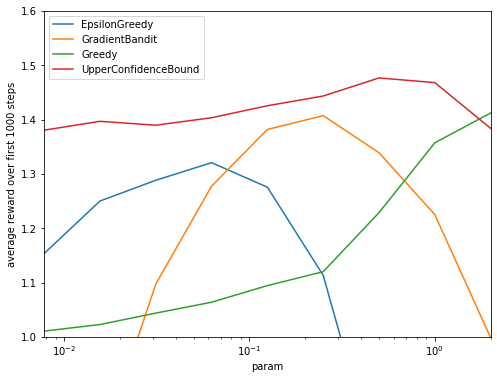

<Figure size 432x288 with 0 Axes>

In [6]:
flow.get.plot_algos()

The above plot approximately reproduces the parameter study plot by Sutton & Barto, with `UpperConfidenceBound` performing the best, and a inverted U-shapes for each algorithm, with the exception of the greedy algorithm with optimistic initialization.

**Understanding discrepancy for the greedy algorithm with optimistic initialization**
There's a little ambiguity about what parameter S & B are plotting against for the greedy algorithm with optimistic initialization, since the line is labeled with a constant initialization, but x-axis shows $Q_0$ as the parameter.  

In our case, we plot with $Q_0$ as a parameter.  With that in mind, we expect a flattening of the average reward with greater $Q_0$ (beyond the x-axis limit shown in the above plot).  The means of our bandit arms are sampled from a normal distribution, so we expect very few arms to end up with means more than a couple of standard deviations greater than 0, so at some point, the effect of increasing $Q_0$ to encourage initial exploration should saturate.